We check the conjecture of systems of the type $I\ddot{x} + B \dot{x} + K x = 0$, for the systems which have both B and K Lyapunov diagonally stable by finding counterexamples.

In [ ]:
import numpy as np
from scipy.linalg import eig, solve_continuous_lyapunov

# Function to generate a random Lyapunov diagonally stable matrix
def generate_lyapunov_diagonally_stable_matrix(n):
    """
    We generate 
    """
    # Start with a positive diagonal matrix
    D = np.random.rand(n)
    
    # create a random positive definite matri

# Function to calculate the block Jacobian matrix
def block_jacobian_matrix(B, K):
    """
    Define the block Jacobian matrix for the system I*ddot{x} + B*dot{x} + K*x = 0.
    B: Damping matrix
    K: Stiffness matrix
    """
    n = B.shape[0]
    # Construct the block matrix
    zero_block = np.zeros((n, n))
    A = np.block([
        [zero_block, np.eye(n)],
        [- K, - B]
    ])
    return A

In [ ]:
n = 10
num_trials = 100

for trial in range(num_trials):
    # Generate Lyapunov diagonally stable matrices B and K
    B = generate_lyapunov_diagonally_stable_matrix(n)
    K = generate_lyapunov_diagonally_stable_matrix(n)
    
    # Define the block Jacobian matrix
    J = block_jacobian_matrix(B, K)
    
    # Find eigenvalues
    eigenvalues = np.linalg.eigvals(J)
    
    # Check if all real parts are negative
    if np.all(np.real(eigenvalues) < 0):
        pass
    else:
        print(f"Trial {trial + 1}: System is unstable, eigenvalues: {eigenvalues}")

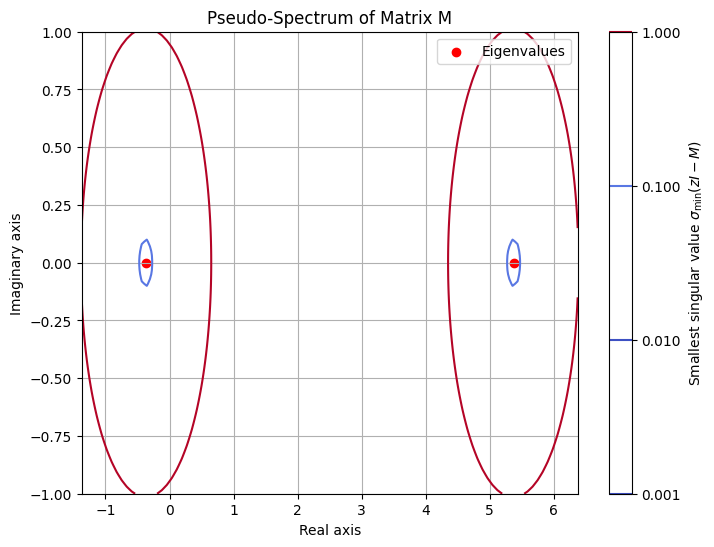

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd

def pseudo_spectrum(M, grid_size=100, epsilon_values=None):
    if epsilon_values is None:
        epsilon_values = [1e-3, 1e-2, 1e-1, 1]

    # Set up the grid of complex numbers (real x imaginary plane)
    real_range = np.linspace(np.min(np.real(np.linalg.eigvals(M))) - 1, 
                             np.max(np.real(np.linalg.eigvals(M))) + 1, grid_size)
    imag_range = np.linspace(np.min(np.imag(np.linalg.eigvals(M))) - 1, 
                             np.max(np.imag(np.linalg.eigvals(M))) + 1, grid_size)
    real, imag = np.meshgrid(real_range, imag_range)
    Z = real + 1j * imag
    
    # Calculate smallest singular value at each point in the complex plane
    sigma_min = np.zeros(Z.shape)
    
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            # Compute the smallest singular value of (zI - M)
            zI_minus_M = Z[i, j] * np.eye(M.shape[0]) - M
            sigma_min[i, j] = svd(zI_minus_M, compute_uv=False)[-1]
    
    # Plot the contour for the pseudo-spectrum based on epsilon levels
    plt.figure(figsize=(8, 6))
    contours = plt.contour(real, imag, sigma_min, levels=epsilon_values, cmap='coolwarm')
    plt.colorbar(contours, label=r'Smallest singular value $\sigma_{\min}(zI - M)$')
    plt.scatter(np.real(np.linalg.eigvals(M)), np.imag(np.linalg.eigvals(M)), color='red', label='Eigenvalues')
    
    plt.xlabel('Real axis')
    plt.ylabel('Imaginary axis')
    plt.title('Pseudo-Spectrum of Matrix M')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
M = np.array([[1, 2], [3, 4]])  # Define your matrix here
pseudo_spectrum(M)



